In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import mne

In [2]:
class GradientArtefactCorrection():

    def __init__(self):
        pass

    def fit_transform(self, raw, event_name, half_window_size=10):

        tr_events, event_id = mne.events_from_annotations(raw, event_id='auto', regexp=event_name, use_rounding=True, chunk_duration=None, verbose=None)

        tr = np.diff(tr_events[:,0])
        tr = np.mean(tr).astype(int)
        tr_s = tr / raw.info['sfreq']

        epochs = mne.Epochs(raw, tr_events, event_id, tmin=0, tmax=tr_s, baseline=None, preload=False).drop_bad()
        epochs_detrended = mne.Epochs(raw, tr_events, event_id, tmin=0, tmax=tr_s, baseline=None, preload=False, detrend=0).drop_bad()
        
        corrected = raw.get_data()
        for t,tr_event in enumerate(tr_events[:,0]):
            start = tr_event
            stop = start + tr + 1
            if stop > raw.n_times:
                stop = raw.n_times

            indice_min = t - half_window_size 
            indice_max = t + half_window_size + 1

            if t < half_window_size:
                indice_min = 0
                indice_max = 2 * half_window_size + 1

            if t > len(epochs) - half_window_size:
                indice_max = len(epochs)
                indice_min = len(epochs) - 2 * half_window_size - 1

            template = epochs_detrended[indice_min:indice_max].average(picks='all').data
            data = epochs[t].get_data()[0]
            corrected[:, start:stop] = data - template

        raw_corrected = mne.io.RawArray(corrected, raw.info)
        raw_corrected.set_annotations(raw.annotations)
        return(raw_corrected)

 

In [74]:
from mne.parallel import parallel_func

def create_lag_signals(original_array, max_lag):
    # Create indices for positive and negative lags
    positive_lag_indices = np.arange(max_lag, len(original_array))
    negative_lag_indices = np.arange(0, len(original_array) - max_lag)
    
    # Generate positive and negative lag signals
    positive_lags_combined = np.zeros((max_lag, len(original_array)))
    negative_lags_combined = np.zeros((max_lag, len(original_array)))
    
    for lag in range(1, max_lag + 1):
        positive_lags_combined[lag - 1, lag:] = original_array[:-lag]
        negative_lags_combined[lag - 1, :-lag] = original_array[lag:]
    
    negative_lags_combined = np.flipud(negative_lags_combined)
    lags_combined = np.vstack([negative_lags_combined, original_array, positive_lags_combined])
    return(lags_combined)


def index_to_signal(index, data, lags_signals_to_regress):
    signal = data[index, :]
    # Perform multiple linear regression
    X = sm.add_constant(lags_signals_to_regress)
    model = sm.OLS(signal, X).fit()
    # Extract coefficients
    coefficients = model.params[1:]
    # Calculate the predicted values of the signals to regress out
    predicted_signals_to_regress = np.dot(lags_signals_to_regress, coefficients)
    # Calculate the residuals (signals after regressing out the effects of the 4 signals)
    residuals = signal - predicted_signals_to_regress
    return(residuals)
        
def cba(raw, picks=['eeg', 'ecg'], cwl_ch_names=['CWL1', 'CWL2', 'CWL3', 'CWL4'], max_lag=10, n_jobs=1, verbose=None):
    
    pick_indices = mne._fiff.pick._picks_to_idx(raw.info, picks=picks)
    cwl_indices = mne._fiff.pick._picks_to_idx(raw.info, picks=cwl_ch_names)

    data = raw.get_data()

    signals_to_regress = data[cwl_indices, :]
    lags_signals_to_regress = list()
    for signal in signals_to_regress:
        lags_combined = create_lag_signals(signal, max_lag=max_lag)
        lags_signals_to_regress.append(lags_combined)
        
    lags_signals_to_regress = np.vstack(lags_signals_to_regress).T

    corrected_data = data.copy()

    if n_jobs == 1:
        for index in pick_indices:
            residuals = index_to_signal(index, data, lags_signals_to_regress)
            corrected_data[index] = residuals

    else:
        parallel, p_fun, _ = parallel_func(
            index_to_signal, n_jobs, total=len(pick_indices), verbose=verbose
        )
        corrected_signals = parallel(
            p_fun(index, data, lags_signals_to_regress)
            for index in pick_indices
        )
        for index, signal in zip(pick_indices,corrected_signals):
            corrected_data[index] = signal
    
    raw_corrected = mne.io.RawArray(data=corrected_data, info=raw.info, verbose=verbose)
    raw_corrected.set_annotations(raw.annotations)
    return(raw_corrected)

In [32]:
raw = mne.io.read_raw_brainvision(r'C:\Users\victor.ferat\Documents\Soraya\EEG-MRI\P05_eyes_closed_mrion.vhdr')
raw.set_channel_types({'CWL1': 'misc', 'CWL2': 'misc', 'CWL3': 'misc', 'CWL4': 'misc', 'ECG': 'ecg'})

GAC = GradientArtefactCorrection()
raw_ga = GAC.fit_transform(raw, event_name='Response/R128', half_window_size=20) 

Extracting parameters from C:\Users\victor.ferat\Documents\Soraya\EEG-MRI\P05_eyes_closed_mrion.vhdr...
Setting channel info structure...
Used Annotations descriptions: ['Response/R128']
0.8
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Loading data for 300 events and 4001 original time points ...


C:\Users\victor.ferat\AppData\Local\Temp\ipykernel_41264\641036989.py:2: RuntimeWarning: The unit for channel(s) CWL1, CWL2, CWL3, CWL4 has changed from V to NA.
  raw.set_channel_types({'CWL1': 'misc', 'CWL2': 'misc', 'CWL3': 'misc', 'CWL4': 'misc', 'ECG': 'ecg'})


0 bad epochs dropped
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Loading data for 300 events and 4001 original time points ...
0 bad epochs dropped
0 41
Loading data for 1 events and 4001 original time points ...
0 41
Loading data for 1 events and 4001 original time points ...
0 41
Loading data for 1 events and 4001 original time points ...
0 41
Loading data for 1 events and 4001 original time points ...
0 41
Loading data for 1 events and 4001 original time points ...
0 41
Loading data for 1 events and 4001 original time points ...
0 41
Loading data for 1 events and 4001 original time points ...
0 41
Loading data for 1 events and 4001 original time points ...
0 41
Loading data for 1 events and 4001 original time points ...
0 41
Loading data for 1 events and 4001 original time points ...
0 41
Loading data for 1 events and 4001 original time points ...
0 41
Loading data for 1 events and 4001 original time points ...
0 41
Load

In [34]:
raw_ga.resample(100)
raw_cba = cba(raw_ga, max_lag=10)

(25742,)
(25742, 84)
(25742,)
(25742, 84)
(25742,)
(25742, 84)
(25742,)
(25742, 84)
(25742,)
(25742, 84)
(25742,)
(25742, 84)
(25742,)
(25742, 84)
(25742,)
(25742, 84)
(25742,)
(25742, 84)
(25742,)
(25742, 84)
(25742,)
(25742, 84)
(25742,)
(25742, 84)
(25742,)
(25742, 84)
(25742,)
(25742, 84)
(25742,)
(25742, 84)
(25742,)
(25742, 84)
(25742,)
(25742, 84)
(25742,)
(25742, 84)
(25742,)
(25742, 84)
(25742,)
(25742, 84)
(25742,)
(25742, 84)
(25742,)
(25742, 84)
(25742,)
(25742, 84)
(25742,)
(25742, 84)
(25742,)
(25742, 84)
(25742,)
(25742, 84)
(25742,)
(25742, 84)
(25742,)
(25742, 84)
(25742,)
(25742, 84)
(25742,)
(25742, 84)
(25742,)
(25742, 84)
(25742,)
(25742, 84)
Creating RawArray with float64 data, n_channels=36, n_times=25742
    Range : 0 ... 25741 =      0.000 ...   257.410 secs
Ready.


In [35]:
raw_cba.plot()

Channels marked as bad:
none


Extracting parameters from C:\Users\victor.ferat\Documents\Soraya\EEG-MRI\P05_eyes_closed_mrion.vhdr...
Setting channel info structure...


C:\Users\victor.ferat\AppData\Local\Temp\ipykernel_41264\132570894.py:3: RuntimeWarning: The unit for channel(s) CWL1, CWL2, CWL3, CWL4 has changed from V to NA.
  raw.set_channel_types({'CWL1': 'misc', 'CWL2': 'misc', 'CWL3': 'misc', 'CWL4': 'misc', 'ECG': 'ecg'})


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 20.480 (s)


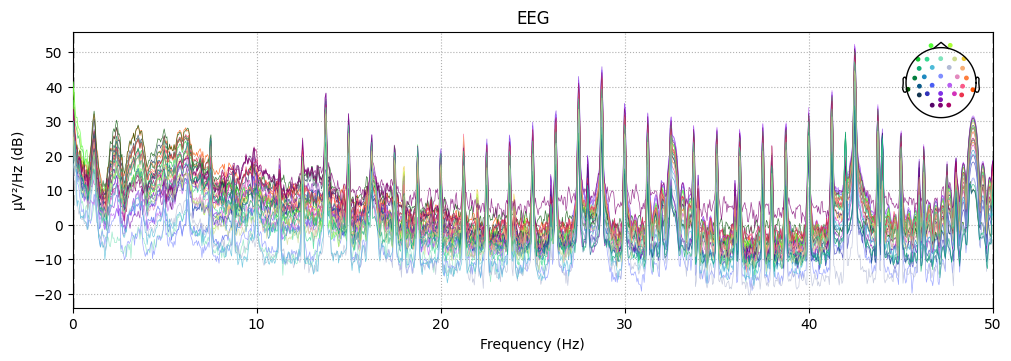

In [39]:
%matplotlib qt
raw = mne.io.read_raw_brainvision(r'C:\Users\victor.ferat\Documents\Soraya\EEG-MRI\P05_eyes_closed_mrion.vhdr')
raw.set_channel_types({'CWL1': 'misc', 'CWL2': 'misc', 'CWL3': 'misc', 'CWL4': 'misc', 'ECG': 'ecg'})
raw.set_montage('standard_1020')
raw.resample(100)
raw.plot_psd(fmin=0, fmax=50, picks='eeg')

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 20.480 (s)


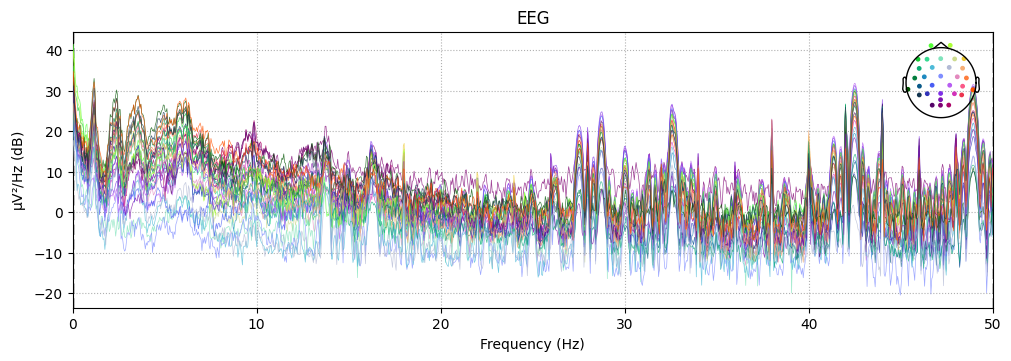

In [40]:
raw_ga.set_montage('standard_1020')
raw_ga.plot_psd(fmin=0, fmax=50, picks='eeg')

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 20.480 (s)


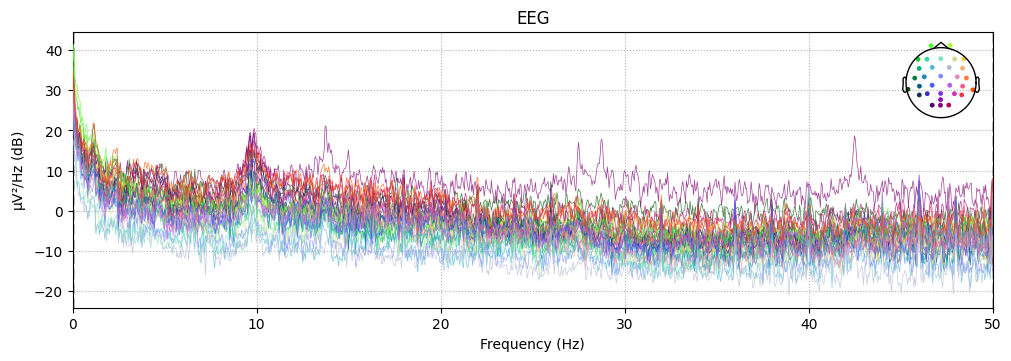

c:\Users\victor.ferat\AppData\Local\miniconda3\envs\soraya\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
c:\Users\victor.ferat\AppData\Local\miniconda3\envs\soraya\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
c:\Users\victor.ferat\AppData\Local\miniconda3\envs\soraya\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


In [36]:
raw_cba.set_montage('standard_1020')
raw_cba.plot_psd(fmin=0, fmax=50, picks='eeg')


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 20.480 (s)


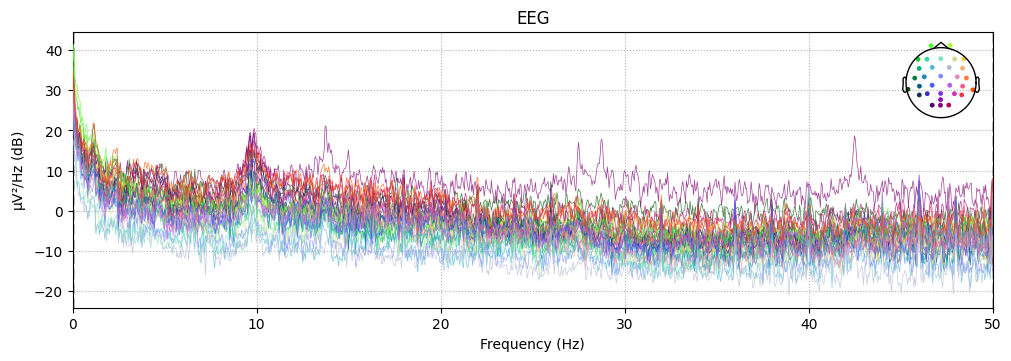

c:\Users\victor.ferat\AppData\Local\miniconda3\envs\soraya\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
c:\Users\victor.ferat\AppData\Local\miniconda3\envs\soraya\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
c:\Users\victor.ferat\AppData\Local\miniconda3\envs\soraya\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
c:\Users\victor.ferat\AppData\Local\miniconda3\envs\soraya\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
c:\Users\victor.ferat\AppData\Local\miniconda3\envs\soraya\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).

In [41]:
%matplotlib qt
raw_cba.plot_psd(fmin=0, fmax=50, picks='eeg')

In [49]:
raw_short = raw_ga.copy().crop(10,20)

In [70]:
%timeit cba(raw_short, verbose=False)

C:\Users\victor.ferat\AppData\Local\Temp\ipykernel_41264\1566618467.py:68: RuntimeWarning: Omitted 29 annotation(s) that were outside data range.
  raw_corrected.set_annotations(raw.annotations)
C:\Users\victor.ferat\AppData\Local\Temp\ipykernel_41264\1566618467.py:68: RuntimeWarning: Omitted 29 annotation(s) that were outside data range.
  raw_corrected.set_annotations(raw.annotations)
C:\Users\victor.ferat\AppData\Local\Temp\ipykernel_41264\1566618467.py:68: RuntimeWarning: Omitted 29 annotation(s) that were outside data range.
  raw_corrected.set_annotations(raw.annotations)
C:\Users\victor.ferat\AppData\Local\Temp\ipykernel_41264\1566618467.py:68: RuntimeWarning: Omitted 29 annotation(s) that were outside data range.
  raw_corrected.set_annotations(raw.annotations)
C:\Users\victor.ferat\AppData\Local\Temp\ipykernel_41264\1566618467.py:68: RuntimeWarning: Omitted 29 annotation(s) that were outside data range.
  raw_corrected.set_annotations(raw.annotations)
C:\Users\victor.ferat\App

955 ms ± 16.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


C:\Users\victor.ferat\AppData\Local\Temp\ipykernel_41264\1566618467.py:68: RuntimeWarning: Omitted 29 annotation(s) that were outside data range.
  raw_corrected.set_annotations(raw.annotations)


937 ms ± 9.94 ms for 10s of data (fs = 100Hz)

In [78]:
%timeit cba(raw_short, n_jobs=6, verbose=False)

100%|█████████████████████████████████████████████████████████████████████████████|  : 32/32 [00:05<00:00,    5.56it/s]
C:\Users\victor.ferat\AppData\Local\Temp\ipykernel_41264\1720627205.py:68: RuntimeWarning: Omitted 29 annotation(s) that were outside data range.
  raw_corrected.set_annotations(raw.annotations)
100%|█████████████████████████████████████████████████████████████████████████████|  : 32/32 [00:00<00:00,  340.42it/s]
C:\Users\victor.ferat\AppData\Local\Temp\ipykernel_41264\1720627205.py:68: RuntimeWarning: Omitted 29 annotation(s) that were outside data range.
  raw_corrected.set_annotations(raw.annotations)
100%|█████████████████████████████████████████████████████████████████████████████|  : 32/32 [00:00<00:00,  339.19it/s]
C:\Users\victor.ferat\AppData\Local\Temp\ipykernel_41264\1720627205.py:68: RuntimeWarning: Omitted 29 annotation(s) that were outside data range.
  raw_corrected.set_annotations(raw.annotations)
100%|██████████████████████████████████████████████████

220 ms ± 5.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


C:\Users\victor.ferat\AppData\Local\Temp\ipykernel_41264\1720627205.py:68: RuntimeWarning: Omitted 29 annotation(s) that were outside data range.
  raw_corrected.set_annotations(raw.annotations)


In [76]:
for n_job in [0,1,2,3,4,5,6,7,8]:
    times = timeit.Timer(partial(to_time, test_items)).repeat(3, 1000)

  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
Note: you may need to restart the kernel to use updated packages.


In [112]:
import datetime
import numpy as np
import pandas as pd

def time_fn( fn, n_test, *args, **kwargs ):
    times = list()
    for n in range(0, n_test):
        start = datetime.datetime.now()
        results = fn( *args, **kwargs )
        end = datetime.datetime.now()
        delta = end - start 
        times.append(delta.total_seconds())
    return(times)

ds = []
for job in range(1,8):
    times = time_fn(cba, 20, raw_short, n_jobs=job, verbose=False)
    for i, time in enumerate(times):
        d = {'n_jobs': job} 
        d['run'] = i
        d['time'] = time
        ds.append(d)

df = pd.DataFrame(ds)

C:\Users\victor.ferat\AppData\Local\Temp\ipykernel_41264\1720627205.py:68: RuntimeWarning: Omitted 29 annotation(s) that were outside data range.
  raw_corrected.set_annotations(raw.annotations)
C:\Users\victor.ferat\AppData\Local\Temp\ipykernel_41264\1720627205.py:68: RuntimeWarning: Omitted 29 annotation(s) that were outside data range.
  raw_corrected.set_annotations(raw.annotations)
C:\Users\victor.ferat\AppData\Local\Temp\ipykernel_41264\1720627205.py:68: RuntimeWarning: Omitted 29 annotation(s) that were outside data range.
  raw_corrected.set_annotations(raw.annotations)
C:\Users\victor.ferat\AppData\Local\Temp\ipykernel_41264\1720627205.py:68: RuntimeWarning: Omitted 29 annotation(s) that were outside data range.
  raw_corrected.set_annotations(raw.annotations)
C:\Users\victor.ferat\AppData\Local\Temp\ipykernel_41264\1720627205.py:68: RuntimeWarning: Omitted 29 annotation(s) that were outside data range.
  raw_corrected.set_annotations(raw.annotations)
C:\Users\victor.ferat\App

<Axes: xlabel='n_jobs', ylabel='time'>

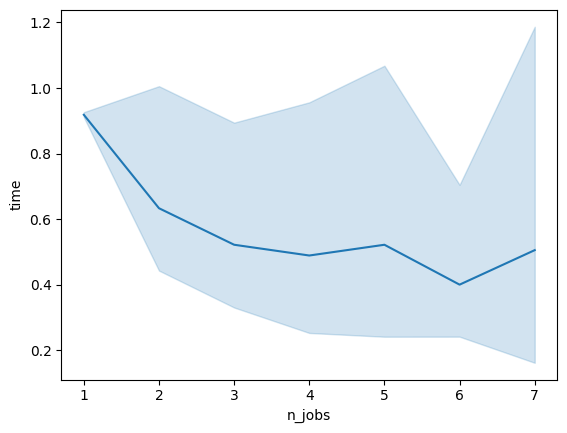

In [115]:
%matplotlib inline
import seaborn as sns

plt.figure()
df = pd.DataFrame(ds)
sns.lineplot(data=df , x='n_jobs', y='time')